In [0]:
import torch
import torch.nn.functional as nn
import torch.autograd as autograd
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import os
from torch.autograd import Variable

device = torch.device('cuda')
%matplotlib inline

In [0]:
mb_size = 64
Z_dim = 100
X_dim = 784
y_dim = 10
h_dim = 128
c = 0
lr = 1e-3

def xavier_init(size):
    in_dim = size[0]
    xavier_stddev = 1. / np.sqrt(in_dim / 2.)
    vec = torch.randn(*size) * xavier_stddev
    vec = vec.to(device)
    vec.requires_grad = True
    return vec

In [0]:
import torchvision
import torchvision.transforms as transforms
dataroot = '../Data'
# load the dataset
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0,), (1,))])
trainset = torchvision.datasets.MNIST(root=dataroot, train=True,
                                        download=False,transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=mb_size,
                                          shuffle=True, num_workers=2)
classes = ('0','1','2','3','4','5','6','7','8','9')

Processing...
Done!


In [0]:
def onehotencoder(x):
    y = np.zeros((x.numpy().shape[0],10))
    for i in range(x.numpy().shape[0]):
        y[i,x[i]] = 1
    return y

dataiter = iter(trainloader)
dataiter = iter(trainloader)
images, labels = dataiter.next()

def mnist_next(dataiter):

    try:
        images, labels = dataiter.next()
        labels = onehotencoder(labels)
        images = images.view(images.numpy().shape[0],28*28)
    except:
        dataiter = iter(trainloader)
        images, labels = dataiter.next()
        labels = onehotencoder(labels)
        images = images.view(images.numpy().shape[0],28*28)
        
    return images.numpy(), labels

def initialize_loader(trainset):
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=mb_size,
                                          shuffle=True, num_workers=2)
    dataiter = iter(trainloader)
    return dataiter

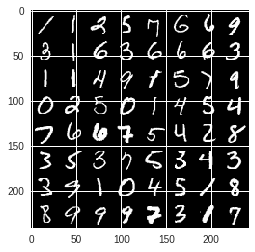

In [0]:
images, labels = mnist_next(dataiter)

dataiter = iter(trainloader)
images, labels = dataiter.next()
img = torchvision.utils.make_grid(images)
npimg = img.numpy()
plt.imshow(np.transpose(npimg, (1, 2, 0)))

In [0]:
""" ==================== GENERATOR ======================== """

Wzh = xavier_init(size=[Z_dim + y_dim, h_dim])
Whx = xavier_init(size=[h_dim, X_dim])

bzvar = torch.zeros(h_dim)
bhvar = torch.zeros(X_dim)

bzvar = bzvar.to(device)
bhvar = bhvar.to(device)

bzh = Variable(bzvar, requires_grad=True)
bhx = Variable(bhvar, requires_grad=True)

def G(z, c):
    inputs = torch.cat([z, c], 1)
    h = nn.relu(torch.mm(inputs, Wzh) + bzh.repeat(inputs.size(0), 1))
    X = nn.sigmoid(torch.mm(h, Whx) + bhx.repeat(h.size(0), 1))
    return X
	

In [0]:
""" ==================== DISCRIMINATOR ======================== """

Wxh = xavier_init(size=[X_dim + y_dim, h_dim])
Why = xavier_init(size=[h_dim, 1])
bxvar = torch.zeros(h_dim)
bhvar = torch.zeros(1)
bxvar = bxvar.to(device)
bhvar = bhvar.to(device)
    
bxh = Variable(bxvar, requires_grad=True)
bhy = Variable(bhvar, requires_grad=True)

def D(X, c):
    inputs = torch.cat([X, c], 1)
    h = nn.relu(torch.mm(inputs, Wxh) + bxh.repeat(inputs.size(0), 1))
    y = nn.sigmoid(torch.mm(h, Why) + bhy.repeat(h.size(0), 1))
    return y 

G_params = [Wzh, bzh, Whx, bhx]
D_params = [Wxh, bxh, Why, bhy]
params = G_params + D_params

In [0]:
""" ===================== TRAINING ======================== """


def reset_grad():
    for p in params:
        p.grad.data.zero_()


G_solver = optim.Adam(G_params, lr=1e-3)
D_solver = optim.Adam(D_params, lr=1e-3)

ones_label = torch.ones(mb_size)
zeros_label = torch.zeros(mb_size)

ones_label = ones_label.to(device)
zeros_label = zeros_label.to(device)

dataiter = initialize_loader(trainset)

for it in range(10000):
    
    z =torch.randn(mb_size, Z_dim)
    X, c = mnist_next(dataiter)
    if X.shape[0]!=mb_size:
        dataiter = initialize_loader(trainset)
        X,c = mnist_next(dataiter)
    X = torch.from_numpy(X)
    c = torch.from_numpy(c.astype('float32'))
    
    z = z.to(device)
    X = X.to(device)
    c = c.to(device)

    
    G_sample = G(z, c)
    D_real = D(X, c)
    D_fake = D(G_sample, c)

    D_loss_real = nn.binary_cross_entropy(D_real, ones_label)
    D_loss_fake = nn.binary_cross_entropy(D_fake, zeros_label)
    D_loss = D_loss_real + D_loss_fake

    D_loss.backward()
    D_solver.step()

    
    reset_grad()

    
    z = torch.randn(mb_size, Z_dim)
    z = z.to(device)

    G_sample = G(z, c)
    D_fake = D(G_sample, c)

    G_loss = nn.binary_cross_entropy(D_fake, ones_label)

    G_loss.backward()
    G_solver.step()

    
    reset_grad()

    
    if it % 1000 == 0:
        print('Iter-{}; D_loss: {}; G_loss: {}'.format(it, D_loss.data.cpu().numpy(), G_loss.data.cpu().numpy()))


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1332: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2016: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))


Iter-0; D_loss: 1.5841729640960693; G_loss: 2.0062294006347656
Iter-1000; D_loss: 0.002952316077426076; G_loss: 8.690977096557617
Iter-2000; D_loss: 0.006217123009264469; G_loss: 7.198022842407227
Iter-3000; D_loss: 0.07866064459085464; G_loss: 6.34443998336792
Iter-4000; D_loss: 0.08540418744087219; G_loss: 5.384490013122559
Iter-5000; D_loss: 0.21359111368656158; G_loss: 4.366875648498535
Iter-6000; D_loss: 0.3166798949241638; G_loss: 4.46971321105957
Iter-7000; D_loss: 0.4782237708568573; G_loss: 3.9360296726226807
Iter-8000; D_loss: 0.4672400951385498; G_loss: 3.3640975952148438
Iter-9000; D_loss: 0.5472660064697266; G_loss: 2.9931273460388184


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1332: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


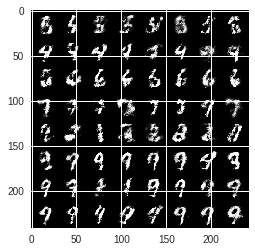

In [0]:
""" ======= Generate images from different classes ===== """



z = torch.randn(mb_size, Z_dim)
discr_codes = torch.zeros(64,10)
z = z.to(device)
discr_codes = discr_codes.to(device)


discr_codes[0:8,5] = 1 
discr_codes[8:16,4] = 1
discr_codes[16:24, 6] = 1
discr_codes[24:32, 7] = 1
discr_codes[32:40, 2] = 1
discr_codes[40:, 9] = 1
samples = G(z,discr_codes)
samples = samples.cpu()
img = samples.data
img = img.view([64,1,28,28])
img = torchvision.utils.make_grid(img)
img = img.permute(1,2,0)
plt.imshow(img.numpy())
